# Import

In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import (
    firwin,
    butter, buttord,
    cheby1, cheb1ord,
    cheby2, cheb2ord,
    ellip, ellipord,
    lfilter,
    freqz, sosfreqz,
    resample,
    tf2zpk,
 )

from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple, Union
import soundfile as sf
import pandas as pd
from scipy.io import wavfile

In [13]:
fs = 12000 # fréquence d'échantillonnage
bands = np.arange(22, 37)   # bande 22 → 36 (car fu < fs/2)

In [14]:
def ansi_band(n):
    f0 = 1000 * 2 ** ((n - 30) / 3)
    fl = f0 / 2 ** (1/6)
    fu = f0 * 2 ** (1/6)
    return fl, f0, fu

def quantize(coeffs, word_length, integer_bits=1, wrap=False):
    """
    Quantifie des coefficients en format virgule fixe Qm.n.
    
    Qm.n = m bits partie entière (avec signe) + n bits fractionnaire.
    Ici : Q(integer_bits).(word_length - integer_bits)
    
    Exemples:
    - quantize(coeffs, 8, 1)  -> Q1.7
    - quantize(coeffs, 16, 3) -> Q3.13
    
    Args:
        coeffs: array des coefficients (float)
        word_length: bits total (inclut bit de signe)
        integer_bits: bits partie entière (1 pour FIR, 3+ pour IIR)
        wrap : False = saturation, True = wrap-around complément a 2
    
    Returns:
        array: coefficients quantifiés (float arrondis)
    """
    
    if word_length <= integer_bits:
        raise ValueError("word_length doit être > integer_bits (inclut bit de signe).")

    # Nombre de bits fractionnaires
    frac_bits = word_length - integer_bits
    
    # Facteur d'échelle pour la partie fractionnaire
    scale = 2**frac_bits
    
    # Passage en entier fixe
    fixed = np.round(coeffs * scale)
    
    # Bornes min/max representables
    MIN = -(2 ** (integer_bits - 1))
    MAX = (2 ** (integer_bits - 1)) - (1 / scale) # ICI - (1 / scale) car c'est la plus petite valeur representable en Qm.n

    
    if wrap:
        # Wrap-around (complement a 2)
        # On ne pense pas que ce soit utile ici, saturation est préférable selon nous
        # En gros quand une valeur dépasse MAX, elle "reboucle" vers MIN et inversement
        
        # Plage totale pour un entier non signé
        range_int = 2 ** word_length
        
        # No joke regardez cette qualité de ligne, on va détailler un peu ;')
        # range_int//2 = 2^(word_length-1) : donc point milieu 
        # fixed.astype(int) convertit en entier pour l'opération modulo
        # Ici modulo est utilisé pour "reboucler" les valeurs hors bornes
        # - (range_int//2) pour soustraire le décalage initial
        fixed = ((fixed.astype(int) + range_int//2) % range_int) - (range_int//2)
    else:
        # Saturation
        # Les valeurs qui dépassent sont "écrasées" aux bornes, donc en théorie moins d'instabilités
        fixed = np.clip(fixed, MIN * scale, MAX * scale)

    return fixed / scale


## Verification standard + guess ordre du filtre

In [15]:
def verify_ansi_standard(
    taps_or_b,
    fl,
    fu,
    fs,
    delta_rel=0.05,
    a=None,
    ripple_db=1.0,
    att_db=60.0
):
    """
    Vérification ANSI S1.11 simplifiée et cohérente FPGA.

    Vérifie :
      - ripple passband ±ripple_db
      - atténuation ≥ att_db hors ±1/3 octave
      - stabilité IIR si applicable

    Supporte :
      - FIR : taps_or_b = taps, a=None
      - IIR BA : taps_or_b=b, a=a
      - IIR SOS : taps_or_b = sos (n_sections, 6), a=None
    """

    ripple_pp_max = 2.0 * ripple_db * (1.0 + delta_rel)
    att_min = att_db * (1.0 - delta_rel)

    f_lo = fl / (2 ** (1 / 3))
    f_hi = fu * (2 ** (1 / 3))

    w = np.linspace(0, fs / 2, 8192, endpoint=False)[1:]

    stable_ok = True

    if a is None and isinstance(taps_or_b, np.ndarray) and taps_or_b.ndim == 2:
        w, h = sosfreqz(taps_or_b, worN=w, fs=fs)
        for sec in taps_or_b:
            if np.any(np.abs(np.roots(sec[3:])) >= 1):
                stable_ok = False
                break
    else:
        if a is None:
            w, h = freqz(taps_or_b, worN=w, fs=fs)
        else:
            w, h = freqz(taps_or_b, a, worN=w, fs=fs)
            stable_ok = np.all(np.abs(np.roots(a)) < 1)

    H_db = 20 * np.log10(np.maximum(np.abs(h), 1e-12))

    f0 = math.sqrt(fl * fu)
    H_db -= H_db[np.argmin(np.abs(w - f0))]

    passband = (w >= fl) & (w <= fu)
    stopband = (w < f_lo) | (w > f_hi)

    ripple_pp = H_db[passband].max() - H_db[passband].min()
    att_stop = -H_db[stopband].max()

    return {
        "ripple_pp_db": float(ripple_pp),
        "att_stop_db": float(att_stop),
        "stable": bool(stable_ok),
        "valid": bool(
            ripple_pp <= ripple_pp_max
            and att_stop >= att_min
            and stable_ok
        ),
        "spec_ripple_pp_max_db": ripple_pp_max,
        "spec_att_min_db": att_min,
    }


In [16]:
wl = 53
delta_rel = 0.05
ripple_db = 1.0
att_db = 60.0

data = []
invalid_filters = []

def check_iir_stability(b, a):
    poles = np.roots(a)
    max_abs_pole = np.max(np.abs(poles))
    return poles, max_abs_pole

iir_types = ['butterworth', 'chebyshev1', 'chebyshev2', 'elliptic']

for iir_type in iir_types:
    for band in bands:
        fl, f0, fu = ansi_band(band)

        # --- Spécifications de design ---
        wp = np.array([fl, fu]) / (fs / 2)
        ws = np.array([fl / (2 ** (1 / 3)), fu * (2 ** (1 / 3))]) / (fs / 2)

        gpass = ripple_db
        gstop = att_db

        # --- Estimation ordre + design ---
        if iir_type == 'butterworth':
            N, Wn = buttord(wp, ws, gpass, gstop)
            b, a = butter(N, Wn, btype='bandpass', output='ba')
        elif iir_type == 'chebyshev1':
            N, Wn = cheb1ord(wp, ws, gpass, gstop)
            b, a = cheby1(N, gpass, Wn, btype='bandpass', output='ba')
        elif iir_type == 'chebyshev2':
            N, Wn = cheb2ord(wp, ws, gpass, gstop)
            b, a = cheby2(N, gstop, Wn, btype='bandpass', output='ba')
        elif iir_type == 'elliptic':
            N, Wn = ellipord(wp, ws, gpass, gstop)
            new_N = N+2
            b, a = ellip(new_N, gpass, gstop, Wn, btype='bandpass', output='ba')
        else:
            raise ValueError("Type IIR inconnu")

        effective_order = len(a) - 1

        # --- Bits entiers nécessaires ---
        max_coeff = max(np.max(np.abs(b)), np.max(np.abs(a)))
        ib = max(2, math.ceil(math.log2(max_coeff)) + 1)
        frac_bits = wl - ib
        scale = 2 ** frac_bits

        # --- Quantification ---
        b_q = quantize(b, wl, integer_bits=ib)
        a_q = quantize(a, wl, integer_bits=ib)
        a_q[0] = 1.0
        
        # --- Test de stabilité (pôles du filtre quantifié) ---
        _, max_abs_pole = check_iir_stability(b_q, a_q)
        stable = bool(max_abs_pole < 1.0)


        # --- Vérification ANSI ---
        result_5 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.05,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )
        result_10 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.10,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )
        result_15 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.15,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )
        result_20 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.20,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )

        octave = (band - 22) // 3 + 1
        filter_nb = (band - 22) % 3 + 1

        # --- Coefficients b ---
        for i, coeff in enumerate(b_q):
            fixed = int(np.round(coeff * scale))
            data.append([
                iir_type, band, octave, filter_nb,
                N, effective_order,
                'b', i,
                ib, frac_bits,
                float(coeff),
                coeff.hex(),     
                bin(fixed),
                result_5["valid"],
                result_10["valid"],
                result_15["valid"],
                result_20["valid"]
            ])

        # --- Coefficients a ---
        for i, coeff in enumerate(a_q):
            fixed = int(np.round(coeff * scale))
            data.append([
                iir_type, band, octave, filter_nb,
                N, effective_order,
                'a', i,
                ib, frac_bits,
                float(coeff),
                coeff.hex(),    
                bin(fixed),
                result_5["valid"],
                result_10["valid"],
                result_15["valid"],
                result_20["valid"]
            ])

df = pd.DataFrame(
    data,
    columns=[
        'iir_type', 'band', 'octave', 'filter_nb',
        'iir_order_N', 'iir_order_effective',
        'coeff_type', 'coeff_index',
        'integer_bits', 'frac_bits',
        'quantized_value',
        'float_hex',         
        'binary_repr',
        'ansi_valid_5',
        'ansi_valid_10',
        'ansi_valid_15',
        'ansi_valid_20'
    ]
)

df.to_csv('auto_iir_coefficients_53bits_all_types.csv', index=False)
print("CSV généré : auto_iir_coefficients_53bits_all_types.csv")

CSV généré : auto_iir_coefficients_53bits_all_types.csv


## Légende du CSV des coefficients IIR quantifiés

- **iir_type** : Type de filtre IIR ('butterworth', 'chebyshev1', 'chebyshev2', 'elliptic')
- **band** : Bande ANSI (22 → 36)
- **octave** : Numéro de l'octave (groupes de 3 bandes 1/3 octave, octave 1 = bandes 22-24, etc.)
- **filter_nb** : Numéro du filtre dans l'octave (1, 2 ou 3)
- **iir_order_N** : Ordre prototype retourné par SciPy (N). Pour un bandpass, l'ordre effectif vaut `2*N`.
- **iir_order_effective** : Ordre effectif du filtre bandpass (= 2*N)
- **coeff_type** : Type de coefficient ('b' pour feedforward/numérateur, 'a' pour feedback/dénominateur)
- **coeff_index** : Index du coefficient dans la section (0..2 pour b0..b2 ou a0..a2)
- **integer_bits** : Bits entiers (signé) utilisés pour quantifier cette section
- **frac_bits** : Bits fractionnaires (= wl - integer_bits)
- **quantized_value** : Valeur flottante quantifiée (celle qui sera représentée en fixe)
- **binary_repr** : `bin(fixed)` (entier signé Python, utile pour debug)
- **float_hex** : Représentation hexadécimale “flottante” Python (`float.hex()`)
- **ansi_valid** : Booléen indiquant si le filtre respecte le masque (±1 dB passband, >=18 dB transition, >=60 dB deep stop + stabilité)

In [17]:
def guess_iir_order(fl, fu, fs, delta_rel=0.05, iir_type='chebyshev1'):
    """
    Utilise directement la fonction ord appropriée pour obtenir l'ordre minimal IIR
    
    Args:
        fl, fu, fs : fréquences et échantillonnage (en Hz)
        delta_rel : marge relative en dB
        iir_type : type de filtre IIR
    
    Returns:
        int : ordre minimal IIR pour respecter les specs avec marge
    """
    
    # Définition des bandes passante et d'arrêt avec marges relatives pour la stabilité
    # Passband légèrement élargie pour garantir le ripple/atténuation
    # Stopband légèrement rétrécie pour l'atténuation/ripple
    wp = [fl * (1 + delta_rel), fu * (1 - delta_rel)]
    ws = [fl * (1 - delta_rel), fu * (1 + delta_rel)]

    # Normalisation des fréquences
    wp = np.array(wp) / (fs/2)
    ws = np.array(ws) / (fs/2)

    gpass = 1 * (1 + delta_rel)    # atténuation max < 1 dB avec marge dans la bande passante
    gstop = 60 * (1 - delta_rel)   # atténuation min > 60 dB avec marge dans la bande d'arrêt

    if iir_type == 'butterworth':
        N, Wn = buttord(wp, ws, gpass, gstop)
    elif iir_type == 'chebyshev1':
        N, Wn = cheb1ord(wp, ws, gpass, gstop)
    elif iir_type == 'chebyshev2':
        N, Wn = cheb2ord(wp, ws, gpass, gstop)
    elif iir_type == 'elliptic':
        N, Wn = ellipord(wp, ws, gpass, gstop)
    else:
        raise ValueError(f"Type IIR inconnu : {iir_type}")
    
    return N

In [18]:
@dataclass(frozen=True) #juste car class EllipticSimPoint n'a pas d'arguments
class EllipticSimPoint:
    """
    On créer une structure de données pour stocker un point de simulation elliptic.
    Chaque point correspond à un couple (ordre N, delta_rel) qui respecte les critères ANSI et de stabilité,
    et contient aussi le nombre minimal de bits de quantification trouvé ;)
    """
    band: int
    fl: float
    fu: float
    N: int
    effective_order: int
    delta_rel: float
    delta_pct: float
    wl_min: int
    integer_bits: int
    frac_bits: int


def _as_list(x: Union[int, Iterable[int]]) -> List[int]:
    """
    Vraiment la fonction pratique ;)
    Convertit un entier ou un itérable d'entiers en liste d'entiers.
    Permet d'accepter aussi bien une bande unique qu'une liste de bandes
    """
    if isinstance(x, int):
        return [x]
    return list(x)


def design_elliptic_bandpass(
    fl: float,
    fu: float,
    fs: float,
    N: int,
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    use_ord_Wn: bool = True,
    ws_factor: float = 2 ** (1 / 3),
    ) -> Tuple[np.ndarray, np.ndarray]:
    
    """
    On construit un filtre elliptique passe-bande (IIR) d'ordre N pour une bande [fl, fu]
    - fl, fu : bornes de la bande passante (Hz)
    - fs : fréquence d'échantillonnage (Hz)
    - N : ordre du filtre (prototype)
    - ripple_db : ondulation max en bande passante (dB)
    - att_db : atténuation min en bande d'arrêt (dB)
    - use_ord_Wn : si True, utilise ellipord pour recalculer Wn (fréquences de coupure normalisées) à partir des specs, sinon Wn=wp (Wp : fréquences de coupure de la pass band)
    - ws_factor : facteur pour définir la bande d'arrêt autour de la bande passante (Ws : fréquences stop band)
    Retourne (b, a) : coefficients du filtre (numérateur, dénominateur)
    """
    
    wp = np.array([fl, fu]) / (fs / 2)
    ws = np.array([fl / ws_factor, fu * ws_factor]) / (fs / 2)
    gpass = ripple_db
    gstop = att_db

    if use_ord_Wn:
        _Nmin, Wn = ellipord(wp, ws, gpass, gstop)
    else:
        Wn = wp

    b, a = ellip(N, gpass, gstop, Wn, btype='bandpass', output='ba')
    return b, a


def iir_integer_bits_needed(b: np.ndarray, a: np.ndarray) -> int:
    """
    Calcule le nombre minimal de bits entiers nécessaires pour coder les coefficients IIR (b et a)
    En gros on prend le max absolu de tous les coefficients, puis log2 + 1 (bit de signe).
    """
    max_iir_coeff = max(float(np.max(np.abs(b))), float(np.max(np.abs(a))))
    if max_iir_coeff == 0:
        return 1
    return int(math.ceil(math.log2(max_iir_coeff)) + 1)


def check_iir_stability_ba(a: np.ndarray) -> Tuple[np.ndarray, float, bool]:
    """
    Vérifie la stabilité d'un filtre IIR
    Retourne les pôles, le module max, et un booléen (True si tous les pôles sont dans le cercle unité)
    """
    poles = np.roots(a)
    max_abs_pole = float(np.max(np.abs(poles))) if poles.size else 0.0
    return poles, max_abs_pole, bool(max_abs_pole < 1.0)


def quantize_iir_ba(
    b: np.ndarray,
    a: np.ndarray,
    wl: int,
    integer_bits: int,
    wrap: bool = False,
) -> Tuple[np.ndarray, np.ndarray, int]:
    
    """
    Quantifie les coefficients b et a d'un filtre IIR en virgule fixe (Qm.n).
    - wl : nombre total de bits (word length)
    - integer_bits : bits pour la partie entière (avec signe)
    - wrap : wrap-around (pas utile ici, on préfère la saturation)
    Retourne (b_q, a_q, frac_bits) : coefficients quantifiés et nb de bits fractionnaires
    """
    if wl <= integer_bits:
        raise ValueError("wl doit être > integer_bits")
    b_q = quantize(b, wl, integer_bits=integer_bits, wrap=wrap)
    a_q = quantize(a, wl, integer_bits=integer_bits, wrap=wrap)
    a_q = np.array(a_q, dtype=float)
    a_q[0] = 1.0
    frac_bits = wl - integer_bits
    return np.array(b_q, dtype=float), a_q, frac_bits


def find_min_word_length_for_valid_elliptic(
    fl: float,
    fu: float,
    fs: float,
    N: int,
    delta_rel: float,
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    wl_max: int = 53,
    wrap: bool = False,
    use_ord_Wn: bool = True,
) -> Optional[Tuple[int, int, int]]:
    """
    Pour un ordre N et un delta_rel donné, on cherche le plus petit word length (<= wl_max)
    qui permet d'obtenir un filtre stable ET qui passe la vérification ANSI
    Retourne (wl_min, integer_bits, frac_bits) ou None si aucun ne passe
    """
    b, a = design_elliptic_bandpass(
        fl=fl, fu=fu, fs=fs, N=N, ripple_db=ripple_db, att_db=att_db, use_ord_Wn=use_ord_Wn
    )
    integer_bits = max(2, iir_integer_bits_needed(b, a))
    wl_start = max(integer_bits + 1, 2)

    for wl in range(wl_start, wl_max + 1):
        b_q, a_q, frac_bits = quantize_iir_ba(b, a, wl=wl, integer_bits=integer_bits, wrap=wrap)
        _poles, _max_abs, stable = check_iir_stability_ba(a_q)
        if not stable:
            continue
        res = verify_ansi_standard(
            b_q, fl, fu, fs, delta_rel=delta_rel, a=a_q, ripple_db=ripple_db, att_db=att_db
        )
        if res["valid"]:
            return wl, integer_bits, frac_bits

    return None


def elliptic_simulate_band(
    band: int,
    fs: float,
    delta_list: Iterable[float] = (0.00, 0.05, 0.10, 0.15, 0.20),
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    wl_max: int = 53,
    use_ord_Wn: bool = True,
    N_search_max: int = 80,
) -> Tuple[int, int, List[EllipticSimPoint]]:
    """
    Simule tous les couples (N, delta_rel) pour une bande ANSI donnée
    Cherche le plus petit N (N_min) pour lequel au moins un delta_rel passe (stabilité+ANSI)
    Puis simule pour tous les N dans [N_min, N_min+N_min/2] et tous les delta_rel donnés
    Retourne (N_min, N_end, liste des points valides).
    """
    fl, _f0, fu = ansi_band(band)
    delta_list = list(delta_list)

    N_min: Optional[int] = None
    for N in range(1, N_search_max + 1):
        ok_any = False
        for d in delta_list:
            out = find_min_word_length_for_valid_elliptic(
                fl, fu, fs, N=N, delta_rel=d, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn
            )
            if out is not None:
                ok_any = True
                break
        if ok_any:
            N_min = N
            break

    if N_min is None:
        return 0, 0, []

    N_end = int(N_min + (N_min // 2))
    points: List[EllipticSimPoint] = []

    for N in range(N_min, N_end + 1):
        b, a = design_elliptic_bandpass(
            fl=fl, fu=fu, fs=fs, N=N, ripple_db=ripple_db, att_db=att_db, use_ord_Wn=use_ord_Wn
        )
        eff_order = int(len(a) - 1)
        for d in delta_list:
            out = find_min_word_length_for_valid_elliptic(
                fl, fu, fs, N=N, delta_rel=d, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn
            )
            if out is None:
                continue
            wl_min, integer_bits, frac_bits = out
            points.append(
                EllipticSimPoint(
                    band=int(band),
                    fl=float(fl),
                    fu=float(fu),
                    N=int(N),
                    effective_order=int(eff_order),
                    delta_rel=float(d),
                    delta_pct=float(d * 100.0),
                    wl_min=int(wl_min),
                    integer_bits=int(integer_bits),
                    frac_bits=int(frac_bits),
                )
            )

    return int(N_min), int(N_end), points

In [19]:
def plot_elliptic_simulation(
    bands_to_plot: Union[int, Iterable[int]],
    fs: float,
    delta_list: Iterable[float] = (0.00, 0.05, 0.10, 0.15, 0.20),
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    wl_max: int = 53,
    use_ord_Wn: bool = True,
    N_search_max: int = 80,
    title: Optional[str] = None,
) -> Tuple[Dict[int, Tuple[int, int]], List[EllipticSimPoint]]:
    """
    Plot delta_rel% (y) vs ordre N (x) pour une ou plusieurs bandes.
    Seuls les points valides (stabilité + ANSI) sont tracés, annotés par wl_min.

    Returns:
      - ranges: dict {band: (N_min, N_end)}
      - points: liste de points valides
    """
    bands_list = _as_list(bands_to_plot)
    delta_list = list(delta_list)

    ranges: Dict[int, Tuple[int, int]] = {}
    all_points: List[EllipticSimPoint] = []

    for band in bands_list:
        N_min, N_end, pts = elliptic_simulate_band(
            band=int(band),
            fs=fs,
            delta_list=delta_list,
            ripple_db=ripple_db,
            att_db=att_db,
            wl_max=wl_max,
            use_ord_Wn=use_ord_Wn,
            N_search_max=N_search_max,
        )
        ranges[int(band)] = (int(N_min), int(N_end))
        all_points.extend(pts)

    if not all_points:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_xlabel("Ordre prototype N")
        ax.set_ylabel("delta_rel (%)")
        ax.set_title(title or "Elliptic simulation (aucun point valide)")
        ax.grid(True, which='both', alpha=0.3)
        plt.show()
        return ranges, all_points

    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = plt.get_cmap('tab10')
    band_to_color = {b: cmap(i % 10) for i, b in enumerate(bands_list)}

    for band in bands_list:
        pts_b = [p for p in all_points if p.band == int(band)]
        if not pts_b:
            continue
        xs = [p.N for p in pts_b]
        ys = [p.delta_pct for p in pts_b]
        ax.scatter(xs, ys, s=30, alpha=0.9, color=band_to_color[int(band)], label=f"Bande {int(band)}")
        for p in pts_b:
            ax.annotate(
                str(p.wl_min),
                (p.N, p.delta_pct),
                textcoords="offset points",
                xytext=(4, 4),
                fontsize=8,
                color=band_to_color[int(band)],
                alpha=0.9,
            )

    # Axe X : plage globale = union des plages demandées
    mins = [v[0] for v in ranges.values() if v[0] > 0]
    maxs = [v[1] for v in ranges.values() if v[1] > 0]
    if mins and maxs:
        ax.set_xlim(min(mins) - 0.5, max(maxs) + 0.5)

    ax.set_yticks([d * 100.0 for d in delta_list])
    ax.set_xlabel("Ordre prototype N")
    ax.set_ylabel("delta_rel (%)")
    ax.set_title(title or "Elliptic: delta_rel% vs ordre (annotation = wl_min)")
    ax.grid(True, which='both', alpha=0.3)
    ax.legend()
    plt.show()

    return ranges, all_points

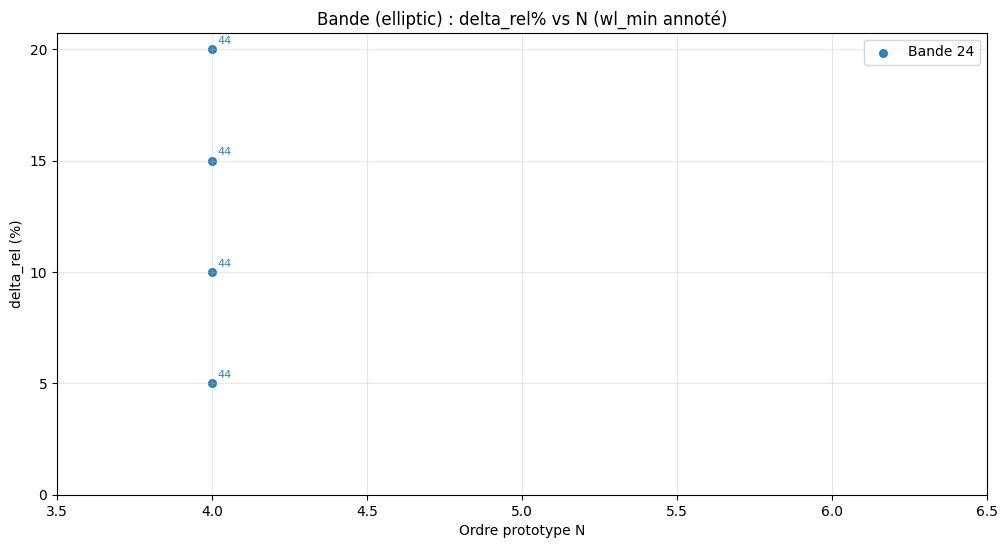

Ranges: {24: (4, 6)}
Nb points valides: 4


In [20]:
ranges_1, points_1 = plot_elliptic_simulation(
    bands_to_plot=24,
    fs=fs,
    delta_list=(0.00, 0.05, 0.10, 0.15, 0.20),
    ripple_db=ripple_db,
    att_db=att_db,
    wl_max=53,
    use_ord_Wn=True,
    N_search_max=60,
    title="Bande (elliptic) : delta_rel% vs N (wl_min annoté)",
)
print("Ranges:", ranges_1)
print("Nb points valides:", len(points_1))

Bande 24, N=4, delta_rel=0.05
fl = 222.72 Hz, f0 = 250.00 Hz, fu = 280.62 Hz
Flottant: stable=True, max|p|=0.998280
ANSI (flottant): {'ripple_pp_db': 1.0002874421290413, 'att_stop_db': 59.0004904131134, 'stable': True, 'valid': True, 'spec_ripple_pp_max_db': 2.1, 'spec_att_min_db': 57.0}
Quantifié minimal trouvé : wl=44 (integer_bits=8, frac_bits=36)
Quantifié: stable=True, max|p|=0.998249
ANSI (quantifié): {'ripple_pp_db': 2.02008496700535, 'att_stop_db': 59.607818799568896, 'stable': True, 'valid': True, 'spec_ripple_pp_max_db': 2.1, 'spec_att_min_db': 57.0}


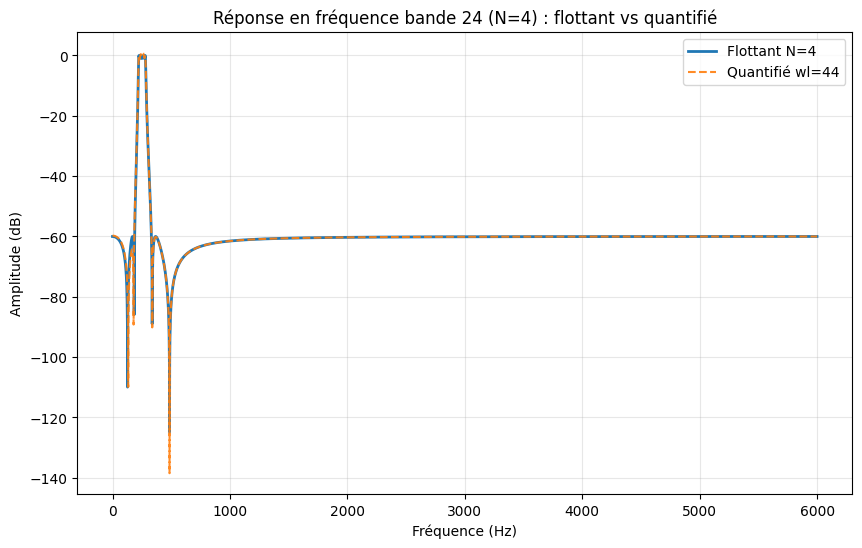

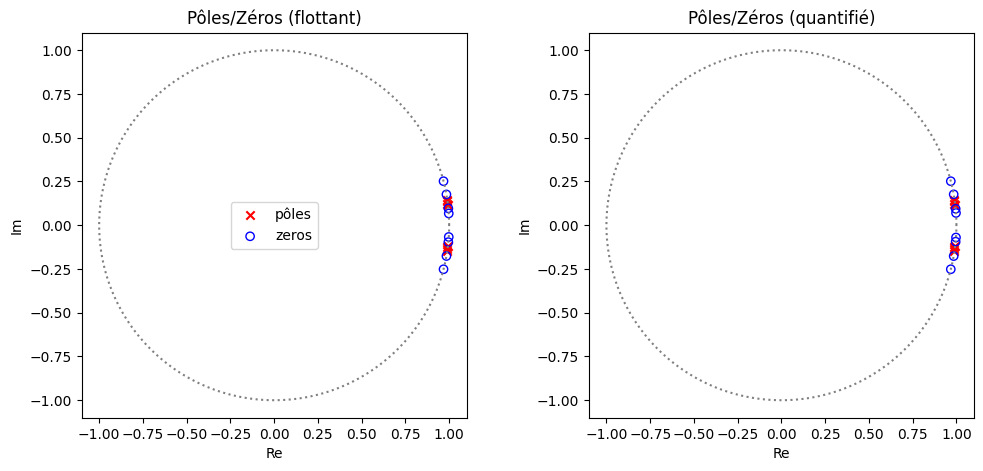

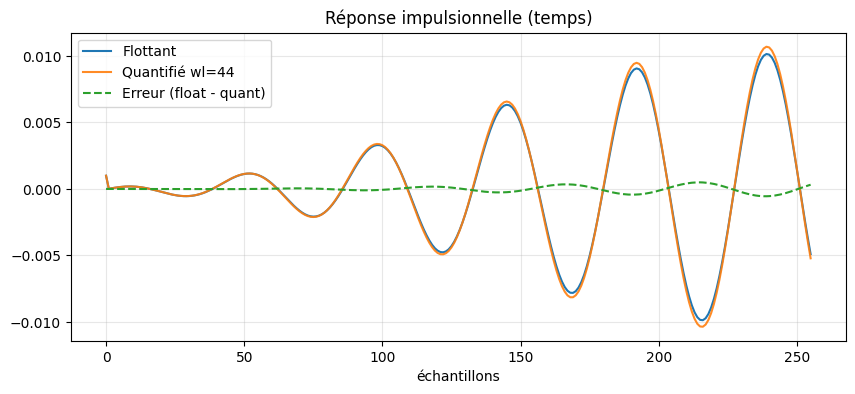


Valeurs quantifiées (float) :
b (quantized float): [0.0009957792062778026, -0.007857264630729333, 0.02723136635904666, -0.05414251927868463, 0.06754527677549049, -0.05414251927868463, 0.02723136635904666, -0.007857264630729333, 0.0009957792062778026]
a (quantized float): [1.0, -7.902134859745274, 27.387745197396725, -54.37653871791554, 67.6431370190694, -53.98725811475015, 26.997014647582546, -7.733636123928591, 0.9716710367792984]

Float hex (coeff quantifiés) :
b hex : ['0x1.05099c8000000p-10', '-0x1.0177835000000p-7', '0x1.be28a0fc00000p-6', '-0x1.bb8917b400000p-5', '0x1.14aa5b2c00000p-4', '-0x1.bb8917b400000p-5', '0x1.be28a0fc00000p-6', '-0x1.0177835000000p-7', '0x1.05099c8000000p-10']
a hex : ['0x1.0000000000000p+0', '-0x1.f9bc93d9cc000p+2', '0x1.b634344ee0000p+4', '-0x1.b30326bb39000p+5', '0x1.0e929282bf000p+6', '-0x1.afe5e7951c800p+5', '0x1.aff3c5a190000p+4', '-0x1.eef3e4eddc000p+2', '0x1.f17eddbae0000p-1']

Coefficients quantifiés (entiers signés) :
b (int): [   68429426  -539

In [ ]:
band = 24
N = 4  
delta_rel_test = 0.05

print(f"Bande {band}, N={N}, delta_rel={delta_rel_test}")

# --- Fréquences de la bande ---
fl, f0, fu = ansi_band(band)
print(f"fl = {fl:.2f} Hz, f0 = {f0:.2f} Hz, fu = {fu:.2f} Hz")

# --- Design floating-point ---
b_f, a_f = design_elliptic_bandpass(fl, fu, fs, N=N, ripple_db=ripple_db, att_db=att_db, use_ord_Wn=True)

poles_f, max_abs_pole_f, stable_f = check_iir_stability_ba(a_f)
print(f"Flottant: stable={stable_f}, max|p|={max_abs_pole_f:.6f}")
res_f = verify_ansi_standard(b_f, fl, fu, fs, delta_rel=delta_rel_test, a=a_f, ripple_db=ripple_db, att_db=att_db)
print("ANSI (flottant):", res_f)

# --- Recherche minimal WL qui passe ---
out = find_min_word_length_for_valid_elliptic(fl, fu, fs, N=N, delta_rel=delta_rel_test, ripple_db=ripple_db, att_db=att_db, wl_max=53, use_ord_Wn=True)
if out is None:
    print("Aucun WL <= 53 ne passe pour ces specs (N, delta_rel). On peut augmenter wl_max si souhaité.")
    wl_min = None
    b_q = a_q = None
else:
    wl_min, integer_bits, frac_bits = out
    b_q, a_q, _ = quantize_iir_ba(b_f, a_f, wl=wl_min, integer_bits=integer_bits, wrap=False)
    poles_q, max_abs_pole_q, stable_q = check_iir_stability_ba(a_q)
    res_q = verify_ansi_standard(b_q, fl, fu, fs, delta_rel=delta_rel_test, a=a_q, ripple_db=ripple_db, att_db=att_db)
    print(f"Quantifié minimal trouvé : wl={wl_min} (integer_bits={integer_bits}, frac_bits={frac_bits})")
    print(f"Quantifié: stable={stable_q}, max|p|={max_abs_pole_q:.6f}")
    print("ANSI (quantifié):", res_q)

# --- Tracé réponses en fréquence ---
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
w, Hf = freqz(b_f, a_f, worN=8192, fs=fs)
ax.plot(w, 20 * np.log10(np.maximum(np.abs(Hf), 1e-12)), label=f"Flottant N={N}", lw=2)
if out is not None:
    w, Hq = freqz(b_q, a_q, worN=8192, fs=fs)
    ax.plot(w, 20 * np.log10(np.maximum(np.abs(Hq), 1e-12)), linestyle='--', label=f"Quantifié wl={wl_min}", lw=1.5, alpha=0.9)
# Marqueurs des bornes
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Amplitude (dB)')
ax.set_title(f"Réponse en fréquence bande {band} (N={N}) : flottant vs quantifié")
ax.grid(True, which='both', alpha=0.3)
ax.legend()
plt.show()

# --- Diagramme pôles/zéros ---

fig, axes = plt.subplots(1, 2 if out is not None else 1, figsize=(12, 5))
if out is not None:
    ax1, ax2 = axes
else:
    ax1 = axes

z_f, p_f, k_f = tf2zpk(b_f, a_f)
ax1.scatter(np.real(p_f), np.imag(p_f), marker='x', color='r', label='pôles'), ax1.scatter(np.real(z_f), np.imag(z_f), marker='o', facecolors='none', edgecolors='b', label='zeros')
ax1.set_title('Pôles/Zéros (flottant)')
ax1.set_xlabel('Re'), ax1.set_ylabel('Im')
# unit circle
theta = np.linspace(0, 2*np.pi, 201)
ax1.plot(np.cos(theta), np.sin(theta), ':', color='gray')
ax1.set_aspect('equal', 'box')
ax1.legend()

if out is not None:
    z_q, p_q, k_q = tf2zpk(b_q, a_q)
    ax2.scatter(np.real(p_q), np.imag(p_q), marker='x', color='r'), ax2.scatter(np.real(z_q), np.imag(z_q), marker='o', facecolors='none', edgecolors='b')
    ax2.set_title('Pôles/Zéros (quantifié)')
    ax2.set_xlabel('Re'), ax2.set_ylabel('Im')
    ax2.plot(np.cos(theta), np.sin(theta), ':', color='gray')
    ax2.set_aspect('equal', 'box')

plt.show()

# --- Réponse impulsionnelle et erreur temporelle ---
imp_len = 256
imp = np.zeros(imp_len); imp[0] = 1.0
h_float = lfilter(b_f, a_f, imp)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(h_float, label='Flottant')
if out is not None:
    h_quant = lfilter(b_q, a_q, imp)
    ax.plot(h_quant, label=f'Quantifié wl={wl_min}', alpha=0.9)
    ax.plot(h_float - h_quant, label='Erreur (float - quant)', linestyle='--')
ax.set_title('Réponse impulsionnelle (temps)')
ax.set_xlabel('échantillons')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# --- Résumé / Coefficients quantifiés (binaire) ---
if out is not None:
    scale = 2 ** frac_bits
    fixed_b = (np.round(b_q * scale)).astype(int)
    fixed_a = (np.round(a_q * scale)).astype(int)

    # Vraies valeurs quantifiées (float) : les coefficients après quantification
    print('\nValeurs quantifiées (float) :')
    print('b (quantized float):', [float(x) for x in b_q])
    print('a (quantized float):', [float(x) for x in a_q])

    # Représentation hex de ces floats (utile pour vérification rapide)
    print('\nFloat hex (coeff quantifiés) :')
    print('b hex :', [c.hex() for c in b_q])
    print('a hex :', [c.hex() for c in a_q])

print('\nTerminé.')